# Graph Neural Nets on Images


This tutorial is based on [this great post](https://medium.com/@BorisAKnyazev/tutorial-on-graph-neural-networks-for-computer-vision-and-beyond-part-1-3d9fada3b80d).

In [1]:
import time
import numpy as np
from scipy.spatial.distance import cdist
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset

import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
from scipy.spatial.distance import cdist


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    
%matplotlib inline
import matplotlib.pyplot as plt


In [2]:
# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.05
NUM_EPOCHS = 5
BATCH_SIZE = 128
IMG_SIZE = 28

# Architecture
NUM_CLASSES = 10

In [3]:
train_indices = torch.arange(0, 59000)
valid_indices = torch.arange(59000, 60000)

custom_transform = transforms.Compose([transforms.ToTensor()])


train_and_valid = datasets.MNIST(root='data', 
                                 train=True, 
                                 transform=custom_transform,
                                 download=True)

test_dataset = datasets.MNIST(root='data', 
                              train=False, 
                              transform=custom_transform,
                              download=True)

train_dataset = Subset(train_and_valid, train_indices)
valid_dataset = Subset(train_and_valid, valid_indices)

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE,
                          num_workers=4,
                          shuffle=True)

valid_loader = DataLoader(dataset=valid_dataset, 
                          batch_size=BATCH_SIZE,
                          num_workers=4,
                          shuffle=False)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE,
                         num_workers=4,
                         shuffle=False)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([128, 1, 28, 28])
Image label dimensions: torch.Size([128])


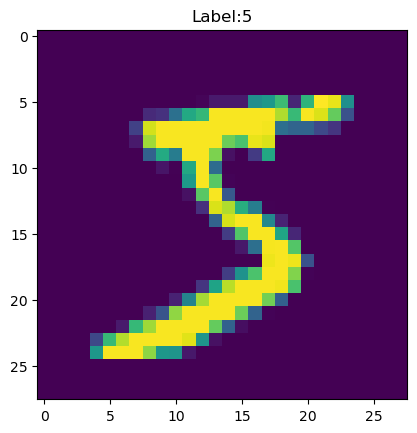

In [4]:
# Peak a data point
for img,c in datasets.MNIST(root='data', train=True,download=True):
    plt.title(f'Label:{c}')
    plt.imshow(img)
    plt.show()
    break

In [5]:

def precompute_adjacency_matrix(img_size):
    col, row = np.meshgrid(np.arange(img_size), np.arange(img_size))
    
    # N = img_size^2
    # construct 2D coordinate array (shape N x 2) and normalize
    # in range [0, 1]
    coord = np.stack((col, row), axis=2).reshape(-1, 2) / img_size

    # compute pairwise distance matrix (N x N)
    dist = cdist(coord, coord, metric='euclidean')
    
    # Apply Gaussian filter
    sigma = 0.05 * np.pi
    A = np.exp(- dist / sigma ** 2)
    A[A < 0.01] = 0
    A = torch.from_numpy(A).float()

    # Normalization as per (Kipf & Welling, ICLR 2017)
    D = A.sum(1)  # nodes degree (N,)
    D_hat = (D + 1e-5) ** (-0.5)
    A_hat = D_hat.view(-1, 1) * A * D_hat.view(1, -1)  # N,N
    
    return A_hat

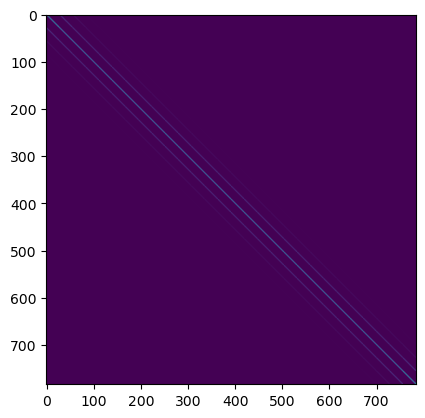

In [6]:
plt.imshow(precompute_adjacency_matrix(28));

In [7]:
precompute_adjacency_matrix(2)

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 1.0000]])

In [8]:

class GraphNet(nn.Module):
    def __init__(self, img_size=28, num_classes=10):
        super().__init__()
        n_rows = img_size**2
        self.fc = nn.Linear(n_rows, num_classes, bias=False)
        A = precompute_adjacency_matrix(img_size)
        self.register_buffer('A', A)
        
    def forward(self, x):
        B = x.size(0) # Batch size
        ### Reshape Adjacency Matrix
        # [N, N] Adj. matrix -> [1, N, N] Adj tensor where N = HxW
        A_tensor = self.A.unsqueeze(0)
        # [1, N, N] Adj tensor -> [B, N, N] tensor
        A_tensor = self.A.expand(B, -1, -1)
        ### Reshape inputs
        # [B, C, H, W] => [B, H*W, 1]
        x_reshape = x.view(B, -1, 1)
        
        # bmm = batch matrix product to sum the neighbor features
        # Input: [B, N, N] x [B, N, 1]
        # Output: [B, N]
        avg_neighbor_features = (torch.bmm(A_tensor, x_reshape).view(B, -1))
        
        logits = self.fc(avg_neighbor_features)
        probas = F.softmax(logits, dim=1)
        return logits, probas

In [9]:
torch.manual_seed(RANDOM_SEED)
model = GraphNet(img_size=IMG_SIZE, num_classes=NUM_CLASSES)
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
from scipy.spatial.distance import cdist

# Apply standard transformations on MNIST and create DataLoader

In [11]:
torch.manual_seed(1)
batch_size=1024
num_epochs=1

In [12]:
train_loader = torch.utils.data.DataLoader(datasets.MNIST('../data', train=True, download=True,
                                                          transform=transforms.Compose([
                                                              transforms.ToTensor(),
                                                              transforms.Normalize((0.1307,), (0.3081,))])),batch_size=batch_size, shuffle=True)

In [13]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))])),batch_size=batch_size, shuffle=False)

In [14]:
class LinearTransformation(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(784, 10, bias=False)
    def forward(self, x):
        return self.fc(x.view(x.size(0), -1))

# Linear Transformation

In [15]:
model=LinearTransformation()
print(model)
optimizer = optim.SGD(model.parameters(), lr=.001, weight_decay=1e-4)
print('number of trainable parameters: %d' % np.sum([np.prod(p.size()) if p.requires_grad else 0 for p in model.parameters()]))

LinearTransformation(
  (fc): Linear(in_features=784, out_features=10, bias=False)
)
number of trainable parameters: 7840


In [16]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 200 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss.item()))

In [17]:
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print(
        '\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))

In [18]:
for epoch in range(1, num_epochs + 1):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.285698

Test set: Average loss: 1.7248, Accuracy: 5359/10000 (54%)



# 2D Conv with Linear Transformation

In [19]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(1, 10, 28, stride=1, padding=14)
        self.fc = nn.Linear(4 * 4 * 10, 10, bias=False)
    def forward(self, x):
        x = F.relu(self.conv(x))
        x = F.max_pool2d(x, 7)
        return self.fc(x.view(x.size(0), -1))

In [20]:
model=ConvNet()
print(model)
optimizer = optim.SGD(model.parameters(), lr=.001, weight_decay=1e-4)
print('number of trainable parameters: %d' % np.sum([np.prod(p.size()) if p.requires_grad else 0 for p in model.parameters()]))
for epoch in range(1, num_epochs + 1):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

ConvNet(
  (conv): Conv2d(1, 10, kernel_size=(28, 28), stride=(1, 1), padding=(14, 14))
  (fc): Linear(in_features=160, out_features=10, bias=False)
)
number of trainable parameters: 9450
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.411742

Test set: Average loss: 2.2232, Accuracy: 1838/10000 (18%)



In [21]:
class GraphNet(nn.Module):
    def __init__(self, img_size=28, pred_edge=False):
        super().__init__()
        self.pred_edge = pred_edge
        N = img_size ** 2
        self.fc = nn.Linear(N, 10, bias=False)
        if pred_edge:
            col, row = np.meshgrid(np.arange(img_size), np.arange(img_size))
            coord = np.stack((col, row), axis=2).reshape(-1, 2)
            coord = (coord - np.mean(coord, axis=0)) / (np.std(coord, axis=0) + 1e-5)
            coord = torch.from_numpy(coord).float()  # 784,2
            coord = torch.cat((coord.unsqueeze(0).repeat(N, 1, 1),
                               coord.unsqueeze(1).repeat(1, N, 1)), dim=2)
            # coord = torch.abs(coord[:, :, [0, 1]] - coord[:, :, [2, 3]])
            self.pred_edge_fc = nn.Sequential(nn.Linear(4, 64),
                                              nn.ReLU(),
                                              nn.Linear(64, 1),
                                              nn.Tanh())
            self.register_buffer('coord', coord)
        else:
            # precompute adjacency matrix before training
            A = self.precompute_adjacency_images(img_size)
            self.register_buffer('A', A)

    @staticmethod
    def precompute_adjacency_images(img_size):
        col, row = np.meshgrid(np.arange(img_size), np.arange(img_size))
        coord = np.stack((col, row), axis=2).reshape(-1, 2) / img_size
        dist = cdist(coord, coord)
        sigma = 0.05 * np.pi

        # Below, I forgot to square dist to make it a Gaussian (not sure how important it can be for final results)
        A = np.exp(- dist / sigma ** 2)
        print('WARNING: try squaring the dist to make it a Gaussian')

        A[A < 0.01] = 0
        A = torch.from_numpy(A).float()

        # Normalization as per (Kipf & Welling, ICLR 2017)
        D = A.sum(1)  # nodes degree (N,)
        D_hat = (D + 1e-5) ** (-0.5)
        A_hat = D_hat.view(-1, 1) * A * D_hat.view(1, -1)  # N,N

        # Some additional trick I found to be useful
        A_hat[A_hat > 0.0001] = A_hat[A_hat > 0.0001] - 0.2

        print(A_hat[:10, :10])
        return A_hat

    def forward(self, x):
        B = x.size(0)
        if self.pred_edge:
            self.A = self.pred_edge_fc(self.coord).squeeze()

        avg_neighbor_features = (torch.bmm(self.A.unsqueeze(0).expand(B, -1, -1),
                                           x.view(B, -1, 1)).view(B, -1))
        return self.fc(avg_neighbor_features)

In [22]:
model=GraphNet()
print(model)
optimizer = optim.SGD(model.parameters(), lr=.001, weight_decay=1e-4)
print('number of trainable parameters: %d' % np.sum([np.prod(p.size()) if p.requires_grad else 0 for p in model.parameters()]))
for epoch in range(1, num_epochs + 1):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)


tensor([[ 0.3400, -0.0852, -0.1736, -0.1938,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [-0.0852,  0.2413, -0.0987, -0.1763, -0.1944,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [-0.1736, -0.0987,  0.2207, -0.1015, -0.1768, -0.1946,  0.0000,  0.0000,
          0.0000,  0.0000],
        [-0.1938, -0.1763, -0.1015,  0.2166, -0.1020, -0.1770, -0.1946,  0.0000,
          0.0000,  0.0000],
        [ 0.0000, -0.1944, -0.1768, -0.1020,  0.2166, -0.1020, -0.1770, -0.1946,
          0.0000,  0.0000],
        [ 0.0000,  0.0000, -0.1946, -0.1770, -0.1020,  0.2166, -0.1020, -0.1770,
         -0.1946,  0.0000],
        [ 0.0000,  0.0000,  0.0000, -0.1946, -0.1770, -0.1020,  0.2166, -0.1020,
         -0.1770, -0.1946],
        [ 0.0000,  0.0000,  0.0000,  0.0000, -0.1946, -0.1770, -0.1020,  0.2166,
         -0.1020, -0.1770],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.1946, -0.1770, -0.1020,
          0.2166, -0.1020],
        [ 0.0000,  

In [23]:
model=GraphNet(pred_edge=True)
print(model)
optimizer = optim.SGD(model.parameters(), lr=.001, weight_decay=1e-4)
print('number of trainable parameters: %d' % np.sum([np.prod(p.size()) if p.requires_grad else 0 for p in model.parameters()]))
for epoch in range(1, num_epochs + 1):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)


GraphNet(
  (fc): Linear(in_features=784, out_features=10, bias=False)
  (pred_edge_fc): Sequential(
    (0): Linear(in_features=4, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
    (3): Tanh()
  )
)
number of trainable parameters: 8225
Train Epoch: 1 [0/60000 (0%)]	Loss: 14.465148

Test set: Average loss: 19.9859, Accuracy: 2930/10000 (29%)



In [24]:
model.A.shape

torch.Size([784, 784])